In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#Read CSV and see general summary information
titanic_df = pd.read_csv("train.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We perform the same preprocessing as we did in the titanic_EDA notebook

In [3]:
titanic_df["hasCabin"] = titanic_df["Cabin"].isna()

In [4]:
pclass_sex_age = titanic_df.groupby(["Pclass", "Sex"])[["Age"]].median()["Age"]
for index, row in titanic_df.iterrows():
    if np.isnan(row["Age"]):
        pclass = row["Pclass"]
        sex = row["Sex"]
        median_age = pclass_sex_age[pclass][sex]
        titanic_df["Age"][index] = median_age
bins = [0,16, 80]
labels = ["child", 0]
child = pd.cut(titanic_df["Age"], bins=bins, labels=labels, right=True)
titanic_df["child_or_gender"] = child
titanic_df["child_or_gender"] = np.where(titanic_df["child_or_gender"] == 0, 
    titanic_df["Sex"], "child"
)

C:\Users\eier\AppData\Local\Temp\ipykernel_25232\1074191325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df["Age"][index] = median_age


In [5]:
titanic_df["Embarked"].fillna("S", inplace=True)

In [6]:
family_members = titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df["FamilySize"] = np.where((0<family_members) & (family_members<4), 
    "Family", "No/Big"
)

In [7]:
titanic_df["Fare"].agg({"min", "max"})

min      0.0000
max    512.3292
Name: Fare, dtype: float64

In [8]:
# intervals are of the form (a,b]. So cannot have the first value 0. Lead to losing passengers
bins = [-0.1,11, 80,520] 
labels = ["Cheapest","Average","Expensive"]
fare_groups = pd.cut(titanic_df["Fare"], bins=bins, labels=labels, right=True)
titanic_df["FareGroups"] = fare_groups

In [9]:
titanic_df = titanic_df.astype({"Sex":"category", "Embarked":"category", "hasCabin":"category",
    "child_or_gender": "category", "FamilySize": "category", "Pclass":"category"                           
})
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      891 non-null    int64   
 1   Survived         891 non-null    int64   
 2   Pclass           891 non-null    category
 3   Name             891 non-null    object  
 4   Sex              891 non-null    category
 5   Age              891 non-null    float64 
 6   SibSp            891 non-null    int64   
 7   Parch            891 non-null    int64   
 8   Ticket           891 non-null    object  
 9   Fare             891 non-null    float64 
 10  Cabin            204 non-null    object  
 11  Embarked         891 non-null    category
 12  hasCabin         891 non-null    category
 13  child_or_gender  891 non-null    category
 14  FamilySize       891 non-null    category
 15  FareGroups       891 non-null    category
dtypes: category(7), float64(2), int64(4), object

In [10]:
y = titanic_df["Survived"]
X = titanic_df.drop([
    "Survived", "Name", "PassengerId", "Cabin", "Ticket", "Sex", 
    "Age", "SibSp", "Parch", "Fare","FamilySize", "FareGroups"
    ], axis=1)

In [11]:
X = pd.get_dummies(X,drop_first=True)
scaler = StandardScaler()
scaler.fit(X * 1.0)
X_std = scaler.transform(X * 1.0)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [12]:
neighbors = [i for i in range(1,20)]
mean_score = []
for n in neighbors:
    clf = KNeighborsClassifier(n_neighbors=n)
    cv = KFold(n_splits=10)
    scores = cross_val_score(clf, X_std, y, cv=cv)
    mean_score.append(scores.mean())

In [13]:
for n, mean in zip(neighbors, mean_score):
    print(f"For {n} neighbors the accuracy is {mean:0.3f}")

For 1 neighbors the accuracy is 0.696
For 2 neighbors the accuracy is 0.747
For 3 neighbors the accuracy is 0.790
For 4 neighbors the accuracy is 0.799
For 5 neighbors the accuracy is 0.805
For 6 neighbors the accuracy is 0.816
For 7 neighbors the accuracy is 0.810
For 8 neighbors the accuracy is 0.813
For 9 neighbors the accuracy is 0.788
For 10 neighbors the accuracy is 0.798
For 11 neighbors the accuracy is 0.796
For 12 neighbors the accuracy is 0.805
For 13 neighbors the accuracy is 0.798
For 14 neighbors the accuracy is 0.809
For 15 neighbors the accuracy is 0.796
For 16 neighbors the accuracy is 0.796
For 17 neighbors the accuracy is 0.795
For 18 neighbors the accuracy is 0.809
For 19 neighbors the accuracy is 0.789


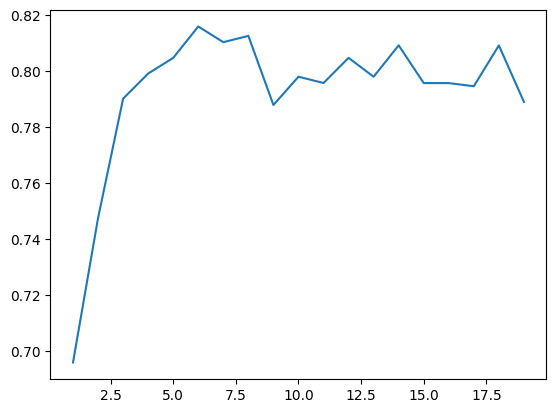

In [14]:
plt.plot(neighbors, mean_score)

In [26]:
knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_std, y)

KNeighborsClassifier(n_neighbors=18)

# Submission

In [27]:
test_df = pd.read_csv("test.csv")

In [28]:
test_df["hasCabin"] = test_df["Cabin"].isna()

In [29]:
#test_df["Age"].fillna(test_df["Age"].median(),inplace=True) #Filling missing ages with median
pclass_sex_age = test_df.groupby(["Pclass", "Sex"])[["Age"]].median()["Age"]
for index, row in test_df.iterrows():
    if np.isnan(row["Age"]):
        pclass = row["Pclass"]
        sex = row["Sex"]
        median_age = pclass_sex_age[pclass][sex]
        test_df["Age"][index] = median_age
bins = [0,16, 80]
labels = ["child", 0]
child = pd.cut(test_df["Age"], bins=bins, labels=labels, right=True)
test_df["child_or_gender"] = child
test_df["child_or_gender"] = np.where(test_df["child_or_gender"] == 0, 
    test_df["Sex"], "child"
)

C:\Users\eier\AppData\Local\Temp\ipykernel_25232\2367378661.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Age"][index] = median_age


In [30]:
test_df["Embarked"].fillna("S", inplace=True)

In [31]:
family_members = test_df["Parch"] + test_df["SibSp"]
test_df["FamilySize"] = np.where((0<family_members) & (family_members<4), 
    "Family", "No/Big"
)

In [32]:
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

In [33]:
# intervals are of the form (a,b]. So cannot have the first value 0. Lead to losing passengers
bins = [-0.1,11, 80,520] 
labels = ["Cheapest","Average","Expensive"]
fare_groups = pd.cut(test_df["Fare"], bins=bins, labels=labels, right=True)
test_df["FareGroups"] = fare_groups

In [34]:
test_df = test_df.astype({"Sex":"category", "Embarked":"category", "hasCabin":"category",
    "child_or_gender": "category", "FamilySize": "category", "Pclass":"category",                          
})


In [35]:
X_test = test_df.drop([
    "Name", "PassengerId", "Cabin", "Ticket", "Sex", 
    "Age", "SibSp", "Parch", "Fare","FamilySize", "FareGroups"
    ], axis=1
)
X_test = pd.get_dummies(X_test,drop_first=True)
X_test_std = scaler.transform(X_test * 1.0)
X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)


In [36]:
pred_test = knn.predict(X_test_std)
test_df["Survived"] = pred_test
submission = test_df[["PassengerId", "Survived"]]
submission.to_csv("Survived_knn_newest_manual_no_cabin_age_imputed.csv",index=False)

The accuracy of this model is about 78.5%